In [1]:
# tensorflow 2+
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

plt.style.use('dark_background')

## Load Models

In [2]:
# 얼굴 인식 모델 (OpenCV)
facenet = cv2.dnn.readNet('models/deploy.prototxt', 'models/res10_300x300_ssd_iter_140000.caffemodel')

# 마스크 인식 모델 (keras)
model = load_model('models/mask_detector.model')

## Load Image

In [3]:
img = cv2.imread('imgs/01.jpg')  # 이미지 불러오기
h, w = img.shape[:2]             # 이미지의 높이와 너비 저장
img.shape

(349, 620, 3)

In [4]:
h, w

(349, 620)

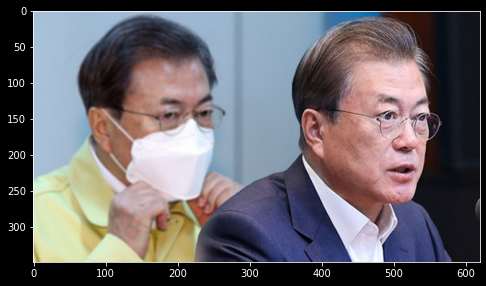

In [5]:
plt.figure(figsize=(8, 5))
plt.imshow(img[:, :, ::-1])      # OpenCV로 이미지 불러오면 BGR로 읽히는데, 이것을 RGB로 변환

## Preprocess Image for Face Detection

In [6]:
# OpenCV의 facenet 모델을 사용하기 때문에, 그 모델에서 학습시킨대로 parameter를 설정함
# dnn 모듈이 사용하는 형태의 이미지를 변형 (axis 순서만 바뀜)
blob = cv2.dnn.blobFromImage(img, scalefactor=1., size=(300, 300), mean=(104., 177., 123.))
blob

array([[[[ 113.,  113.,  113., ...,  -80.,  -81.,  -81.],
         [ 113.,  113.,  113., ...,  -80.,  -80.,  -80.],
         [ 113.,  113.,  113., ...,  -79.,  -80.,  -80.],
         ...,
         [  60.,   38.,  -13., ...,  -79.,  -81.,  -81.],
         [  62.,   44.,   -8., ...,  -79.,  -81.,  -81.],
         [  64.,   44.,   -4., ...,  -78.,  -82.,  -82.]],

        [[  15.,   15.,   15., ..., -158., -159., -159.],
         [  15.,   15.,   15., ..., -158., -158., -158.],
         [  15.,   15.,   15., ..., -157., -158., -158.],
         ...,
         [  44.,   31.,   -8., ..., -160., -159., -159.],
         [  45.,   35.,   -3., ..., -159., -159., -159.],
         [  45.,   35.,   -1., ..., -158., -160., -160.]],

        [[  43.,   43.,   43., ..., -107., -108., -108.],
         [  43.,   43.,   43., ..., -107., -107., -107.],
         [  43.,   43.,   43., ..., -106., -107., -107.],
         ...,
         [ 100.,   93.,   62., ..., -103., -103., -103.],
         [ 100.,   97.,   

In [7]:
blob.shape

(1, 3, 300, 300)

In [8]:
# 모델에 input 데이터 넣어주기
facenet.setInput(blob)

# 결과를 추론하고, dets에 저장
dets = facenet.forward()

In [9]:
dets

array([[[[0.        , 1.        , 0.9998375 , ..., 0.18436447,
          0.88815635, 0.75966525],
         [0.        , 1.        , 0.86180526, ..., 0.17003933,
          0.41512516, 0.7519363 ],
         [0.        , 1.        , 0.12055866, ..., 4.0087085 ,
          4.838731  , 4.9869113 ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]]], dtype=float32)

In [10]:
dets.shape

(1, 1, 200, 7)

In [11]:
print(dets[0, 0, 1, 0], 
      dets[0, 0, 1, 1], 
      dets[0, 0, 1, 2], 
      dets[0, 0, 1, 3], 
      dets[0, 0, 1, 4], 
      dets[0, 0, 1, 5], 
      dets[0, 0, 1, 6])

0.0 1.0 0.86180526 0.19780245 0.17003933 0.41512516 0.7519363


## Detect Faces

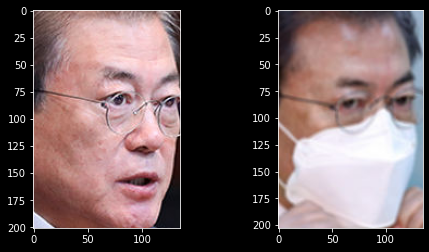

In [12]:
faces = []

# 여러개의 얼굴이 인식될 수 있기때문에 for문 사용
for i in range(dets.shape[2]):     # range : 0 ~ 200
    confidence = dets[0, 0, i, 2]  # detection한 결과의 신뢰도
    if confidence < 0.5:           # 신뢰도가 0.5 미만인 결과는 pass함
        continue
    
    # x, y의 바운딩박스 구하기
    x1 = int(dets[0, 0, i, 3] * w)
    y1 = int(dets[0, 0, i, 4] * h)
    x2 = int(dets[0, 0, i, 5] * w)
    y2 = int(dets[0, 0, i, 6] * h)
    
    # 원본이미지에서 바운딩박스에 담긴 얼굴만 잘라내기
    face = img[y1:y2, x1:x2]
    
    # faces에 잘라낸 얼굴 이미지를 저장
    faces.append(face)
    
plt.figure(figsize=(8, 4))

# faces에 저장된 얼굴 이미지 확인
for i, face in enumerate(faces):
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:, :, ::-1])

## Detect Masks from Faces

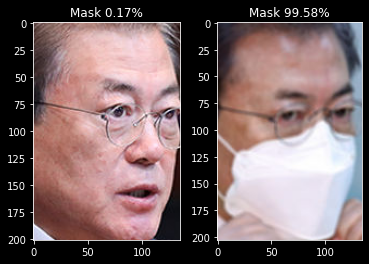

In [13]:
# 마스크를 인식하는 모델 돌리기

# faces에 저장된 얼굴 갯수만큼 돌면서 마스크 착용여부 확인
for i, face in enumerate(faces):
    # 이미지 전처리
    face_input = cv2.resize(face, dsize=(224, 224))           # 이미지 크기 변환
    face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)  # 이미지의 컬러시스템 변경(BGR -> RGB)
    face_input = preprocess_input(face_input)                 # mobilenet_v2에서 하는 preprocessing과 똑같이 해줌
                                                              # -> shape : (224, 224, 3)
    face_input = np.expand_dims(face_input, axis=0)           # shape을 (1, 224, 224, 3)으로 변환시키기 위해 차원추가
                                                              # 그래야 모델에 넣을 수 있음
    # 예측
    mask, nomask = model.predict(face_input).squeeze()        # 마스크를 쓴 확률과 쓰지 않은 확률을 각각 저장
    
    plt.subplot(1, len(faces), i+1)     # 인식된 얼굴 갯수만큼 그리기
    plt.imshow(face[:, :, ::-1])        # BGR -> RGB 변환
    plt.title('Mask %.2f%%' % (mask * 100))  # 마스크 쓴 확률(mask)을 소숫점 2째자리까지 표시
    
    plt.savefig('result/output_img3.png')